<a href="https://colab.research.google.com/github/lemonbuilder/EXPLORATION/blob/main/E-03/%5BE-03%5DStockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-03] STOCK PREDICTION


<br>

< 목 차 >

###I.   서 론

###II.  본 론

1.   **005930.KS (삼성전자)**  
    1) 분석 및 예측  
    2) 소 결   

2.   **AMZN (아마존)**  
    1) 분석 및 예측  
    2) 소 결   

3.   **NKE (나이키 Class B)**  
    1) 분석 및 예측  
    2) 소 결   


###III. 결 론

<br><br><br>





---

# **I.  서 론**

<br>


####**[ 배경 및 의의 ]**

미래를 미리 알 수 있다면 얼마나 좋을까. 우리가 무속인이나 점성술사처럼 다가올 운명을 좌우할 수는 없겠지만, 과거와 현재의 데이터를 기반으로 앞으로 일어날 사건을 통계적으로 예측할 수는 있다. 예측은 다가올 변화에 대비하여 보다 나은 선택과 행동을 하는 데에 도움을 주지만, 그 한계 또한 명확하다. 

이번 Exploration에서는 예측이 가능한 전제조건과 데이터의 활용, 예측 기법을 알아본다. 특히, 일정 시간 간격으로 배치된 데이터들의 수열인 시계열(time series) 예측을 수행해보자.

<br>

####**[ 목표 ]**
*   데이터의 정상성(stationarity)에 대한 이해
*   예측모델의 개념 및 구현방법 숙지
*   실제 데이터셋을 활용한 예측 실행
*   예측 정확도를 확인하고, 이를 평가하는 방법 학습
*   해결되지 않은 부분에 대한 인지 및 향후 보완사항 검토


<br><br><br>




---

# **II. 본 론**




##**1. 005930.KS (삼성전자)**

<br><br>

###**1) 분석 및 예측**

<br>

Yahoo Finance에서 제공하는 데이터셋을 활용하여 주가정보를 불러오자. 첫 번째로 분석해볼 데이터는 '005930.KS', 삼성전자 주식이다. 2022.5.4 기준으로 주당 67,900원이지만 분석에 사용할 데이터셋은 약 2년 가량 경과된 자료다. 

데이터를 불러온 후 Close(종가) 컬럼을 변수로 지정한다.
Series 객체임을 확인하고, head() 메서드를 이용하여 데이터 상위 5개 행을 읽어보자.

In [46]:
# 데이터 셋팅
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_filepath = '/content/drive/MyDrive/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  

print(f'- shape: {df.shape}')
print(f'- data 정보: {df.keys()}') 
print(f'{df.info()}\n') 

ts = df['Close']
print(type(ts))
print(ts.head())

- shape: (250, 6)
- data 정보: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB
None

<class 'pandas.core.series.Series'>
Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64


<br><br>

데이터 내에 결측치가 있다면 통계분석 시 오류가 발생하거나 분석 결과를 저하시킬 수 있으므로 이를 확인할 필요가 있다. 결측치 추적에는 isna()를 활용한다.

결측치가 있을 경우, 데이터를 삭제 또는 보간(interploate)한다. 

In [3]:
# 결측치 확인
ts[ts.isna()]

# (결측치 있을 경우, 보간)
ts = ts.interpolate(method='time')  
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

<br><br>

보다 자세히 데이터를 파악하기 위해 그래프를 그려보도록 하자. 

In [4]:
# 로그변환
ts_log = np.log(ts)

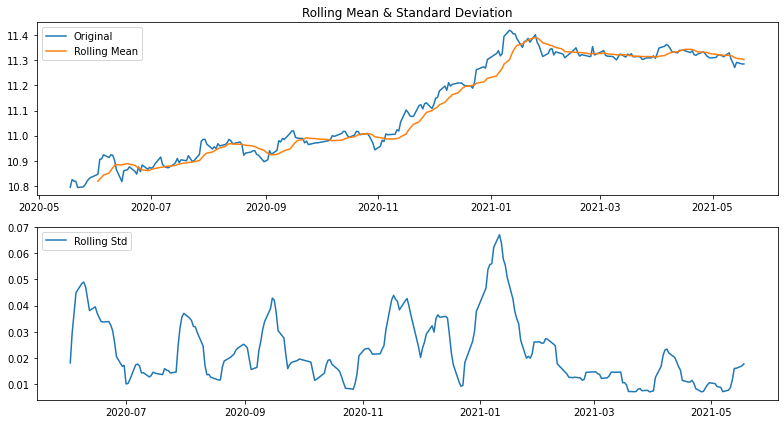

In [36]:
# 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # moving average
    rolstd = timeseries.rolling(window=window).std() # std MA
    plt.rcParams['figure.figsize'] = (11,6)
    plt.subplot(211)
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(loc='upper left')
    plt.subplot(212)
    plt.plot(rolstd, label='Rolling Std')
    plt.legend(loc='upper left')
    plt.tight_layout()

plot_rolling_statistics(ts_log, window=12)

<br><br>

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행한다.

아래 보는 것과 같이, p-value가 0.59로 현 상태로는 정상성을 지닌다고 보기 어렵다.

In [6]:
# Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)' % key] = value
    print(dfoutput)    

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value(1%)              -3.456888
Critical Value(5%)              -2.873219
Critical Value(10%)             -2.572994
dtype: float64


<br><br>

비정상성을 지닌 시계열을 활용할 수 있도록 정상성을 높이는 방법에는 크게 두 가지가 있다.

*   안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형; 정성적 방법
*   시계열 분해(Time series decomposition) 기법의 적용



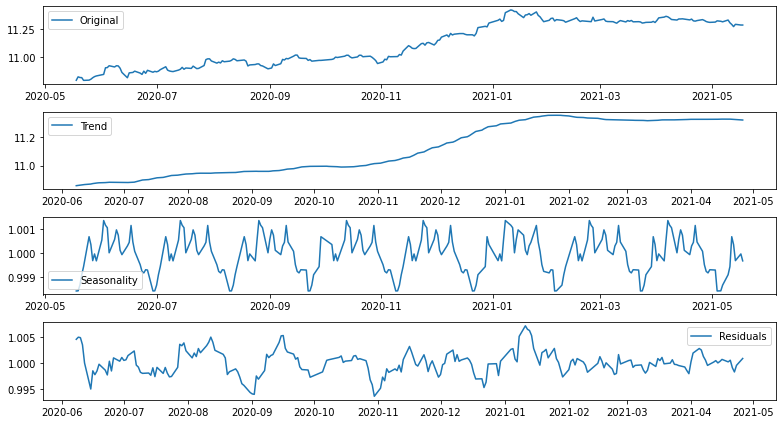

In [7]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose                         
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30)   

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<br><br>

이제 Residual을 확인해보자. Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 한다. 이는 설명될 수 없는 요인에 의한 변화, 즉 예측불가한 임의의 변동을 의미한다. 다시 말해 Trend, Seasonality, Residual을 합하면 Original과 같다.

*   Original = Trend + Seasonality + Residual

Decomposition은 시계열 데이터를 이해하는 중요한 관점을 제시해 준다.

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value(1%)            -3.461879e+00
Critical Value(5%)            -2.875404e+00
Critical Value(10%)           -2.574159e+00
dtype: float64


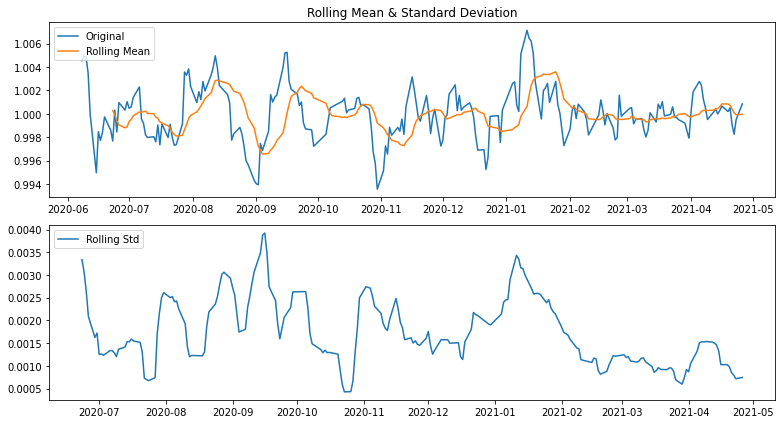

In [8]:
# Residual 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

<br><br>

이제 학습 및 테스트를 준비하자.

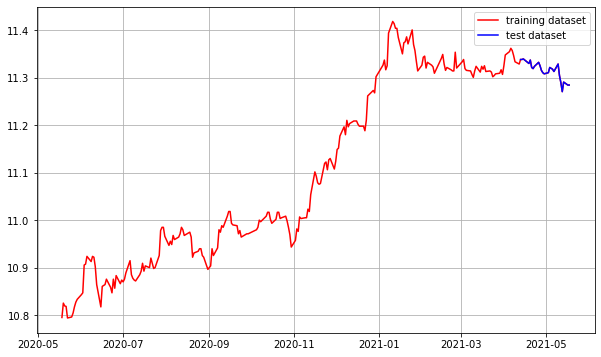

In [9]:
''' 학습, 테스트 데이터셋 생성 '''
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

<br><br>

ARIMA(Autoregressive Integrated Moving Average)를 사용하면 시계열 데이터 예측 모델을 자동으로 만들 수 있다. 


*   ARIMA = AR(Autoregressive) + I(Integrated) + MA(Moving Average)

<br>

ARIMA를 효과적으로 활용하려면 파라미터(모수)를 설정하는 것이 중요하다. ARIMA의 적절한 파라미터 p(자기회귀 모형(AR)의 시차), d(차분 누적(I) 횟수), q(이동평균 모형(MA)의 시차)를 선택하는 대표적인 방법에는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)가 있다.

PACF는 ACF가 모든 시계열 데이터의 특성을 분석하는 것에 한계가 있기에 추가적인 분석이 필요에 따라 사용된다. t와 t+k 간 다른 y값의 영향력은 배제하고 측정하는 방식이다. 즉 시차 k에서의 k단계만큼 떨어져있는 모든 데이터들 간의 상관관계를 말한다.[1] 

<br>

[ 지표 해석하기 ]

*   시차 p, q 이후에는 0으로의 절단형태가 나타난다.
*   시계열 데이터가 AR의 특성을 띠는 경우, ACF는 천천히 감소, PACF는 급격히 감소한다.
*   MA의 특성을 띠는 경우, ACF는 급격히 감소, PACF는 천천히 감소한다.


*   ACF 반환값의 절대값이 커질수록 시차 시계열 데이터의 상관성이 크다. 
*   ACF는 정상성 데이터에 대해서는 0으로 빠르게 떨어지고, 비정상성 데이터에는 천천히 수치가 떨어진다.
*   MA를 고려할 필요가 없다면 q=0으로 둘 수 있다.
*   PACF가 0이면, 현재 데이터와 p 시점 떨어진 이전의 데이터 간의 상관도가 0임을 의미한다.






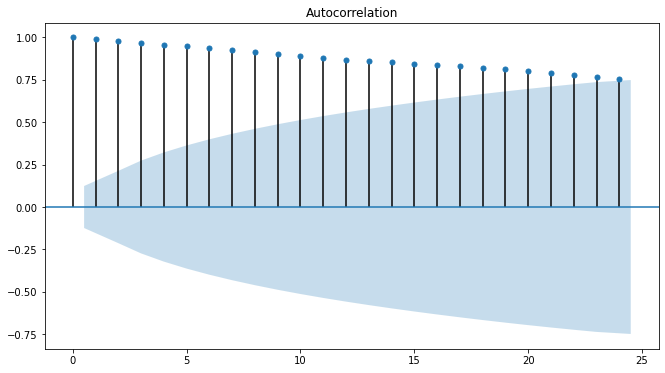

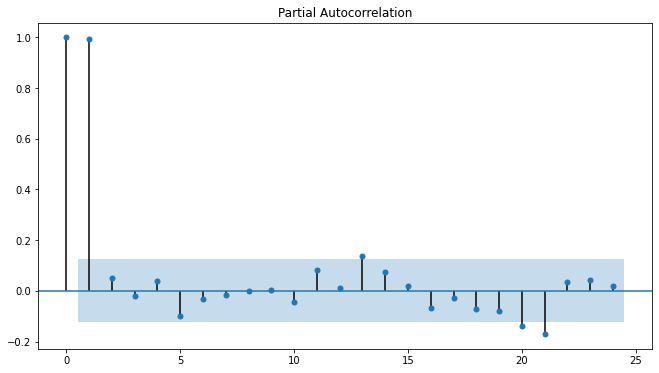

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value(1%)            -3.456996e+00
Critical Value(5%)            -2.873266e+00
Critical Value(10%)           -2.573019e+00
dtype: float64


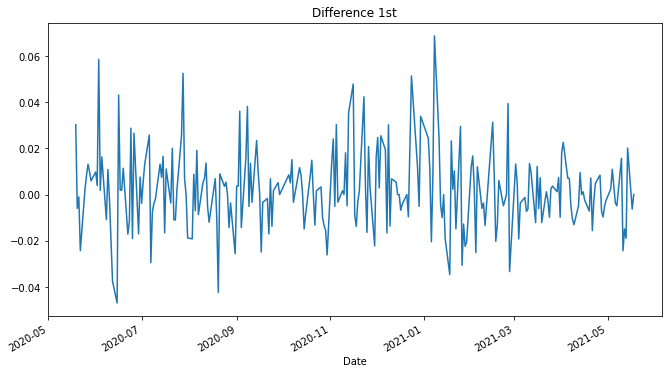

In [11]:
# 차분 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value(1%)            -3.457894e+00
Critical Value(5%)            -2.873659e+00
Critical Value(10%)           -2.573229e+00
dtype: float64


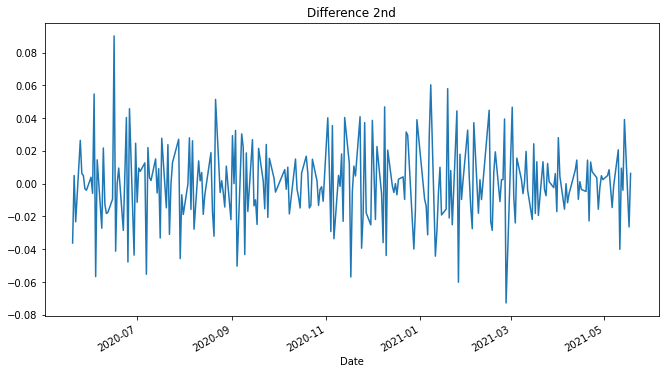

In [12]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<br><br>

위의 분석 결과, 데이터는 AR의 특성을 띠는 것으로 판단된다. 그래프의 형태와 절단점의 위치를 참고하여 파라미터(모수)를 설정하였다. q의 경우, 값을 조정해가며 결과를 살펴보았다. 차분은 1회만 실시하는 게 더 낫다고 판단된다.

다음은 p=1, d=1, q=0을 적용한 ARIMA model 분석결과다.

In [56]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,0))    # q값 조정해봄 -> 0 채택

fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 05 May 2022   AIC                          -1164.792
Time:                        10:19:18   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.049    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

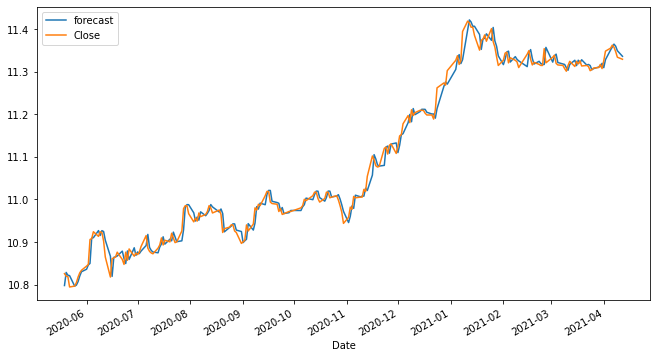

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-04-06    11.362103
2021-04-07    11.357441
2021-04-08    11.346871
2021-04-09    11.333799
2021-04-12    11.329003
Name: Close, Length: 225, dtype: float64
225


In [57]:
fitted_m.plot_predict(dynamic=False)

plt.show()

print(train_data)
print(len(train_data))

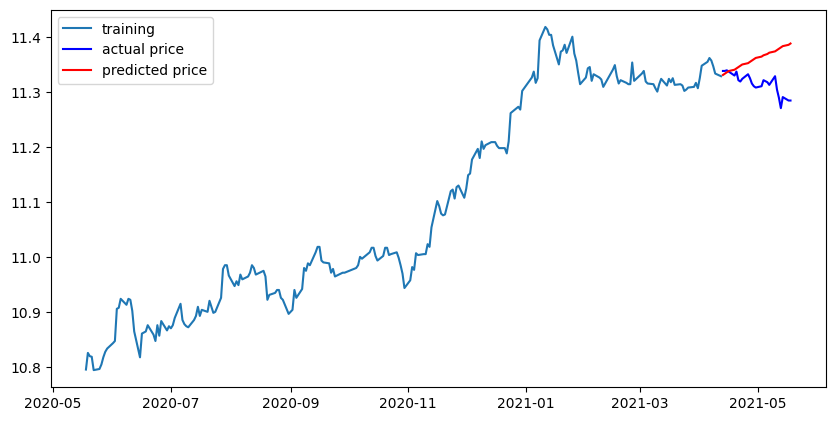

In [58]:
# Forecast
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # array(3개) 각각 배정

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

<br><br>

다음은 모델을 평가하기 위해 MSE, MAE, RMSE, MAPE를 계산한 결과이다. 

평균절대비오차인 **MAPE**(mean absolute percentage error)를 **4.68%** 까지 낮추었다. 

In [59]:
# 원본 스케일의 오차계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('► MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('► MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('► RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('► MAPE: {:.2f}%'.format(mape*100))

► MSE:  22087366.126154922
► MAE:  3791.3511527213127
► RMSE:  4699.719792301976
► MAPE: 4.68%


<br><br><br>

###**2) 소 결**

<br>

삼성전자 주식 데이터를 분석하고, 데이터의 정상성(starionary)을 획득하여 시계열 예측을 실시했다. 해당 데이터 상 가장 최근의 주가(약 1개월분)을 예측하였다.

<br>

**Augmented Dickey-Fuller Test 결과**
*   데이터 가공 전 p-value(초기값): 0.59
*   데이터 가공 및 시계열 분해 후 p-value(최저값): 2.183738e-28

**ARIMA model 파라미터(모수)**
*   p=1, d=1, q=0

**예측 정확도 평가**
*   MAPE: 4.68%


<br>

데이터를 가공하고, 변형하는 과정을 통해 점차 데이터의 정상성을 높일 수 있었고, 시계열 분해를 통해 p-value를 성공적으로 낮출 수 있었다. 이렇게 데이터가 안정적인 형태를 띨 때, 과거의 패턴을 기준으로 미래의 움직임을 예측할 수 있다. 

다만, Trend와 Seasonality를 제거하고, 특히 예측이 불가한 Residual까지 제거한 상태에서 실시한 예측이 현실세계를 얼마나 반영할 수 있는지에 대해서는 의문이 남는다. 현실에서는 이러한 요인들을 무시할 수 없기 때문이다.  

-

<br><br><br><br><br><br>




---




##**2. AMZN (아마존)**

<br><br>

###**1) 분석 및 예측**

<br>

두 번째로 분석해볼 데이터는 'AMZN', 아마존 주식이다. 온라인 전자상거래, 데이터센터를 통한 클라우드 컴퓨팅 서비스, 아마존 프라임 등 미디어 사업을 수행하고 있는 기업이다.  

데이터를 불러온 후 Close(종가) 컬럼을 변수로 지정한다.
Series 객체임을 확인하고, head() 메서드를 이용하여 데이터 상위 5개 행을 읽어보자.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_filepath = '/content/drive/MyDrive/data/AMZN.csv'
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  

print(f'- shape: {df1.shape}')
print(f'- data 정보: {df1.keys()}') 
print(f'{df1.info()}\n') 

ts1 = df1['Close']
print(type(ts1))
print(ts1.head())


- shape: (253, 6)
- data 정보: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-04-29 to 2022-04-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None

<class 'pandas.core.series.Series'>
Date
2021-04-29    3471.310059
2021-04-30    3467.419922
2021-05-03    3386.489990
2021-05-04    3311.870117
2021-05-05    3270.540039
Name: Close, dtype: float64


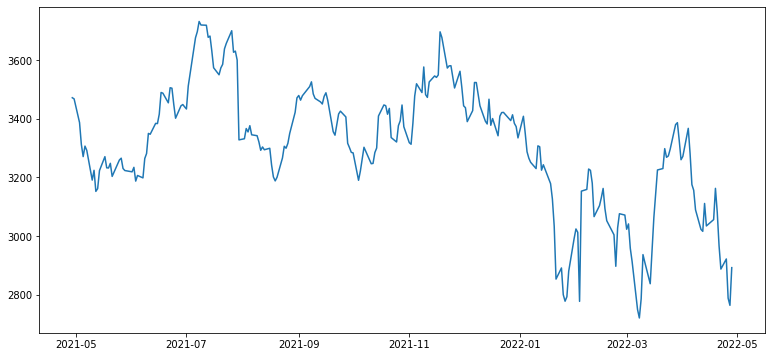

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

# 시계열(time series) 데이터 차트
plt.plot(ts1)

In [ ]:
# 결측치 측정
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


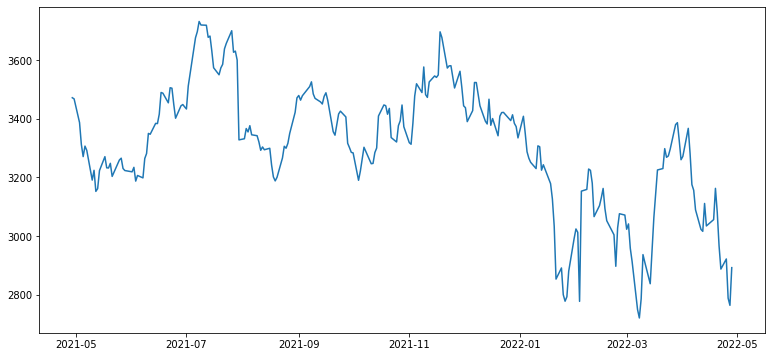

In [ ]:
# 결측치 있을 시 보간(보간기준 time) 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무 재확인
print(ts1[ts1.isna()])

# 그래프 재확인
plt.plot(ts1)

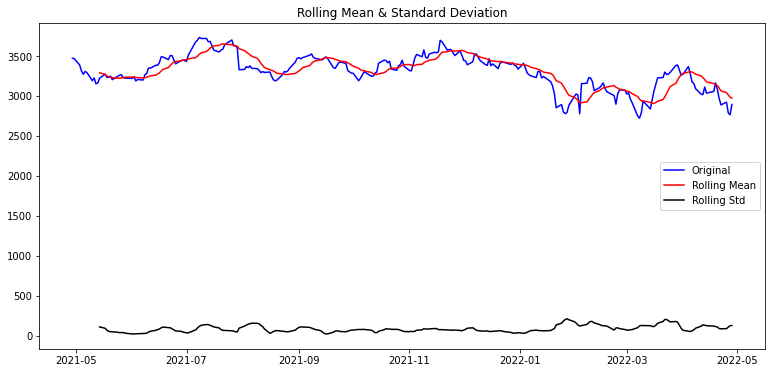

In [ ]:
''' 구간 통계치(Rolling Statistics) 시각화 '''
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 실행
plot_rolling_statistics(ts1, window=12)

In [ ]:
''' statsmodels 패키지와 adfuller 메서드 '''

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

<br><br>

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행한다.

아래 보는 것과 같이, p-value가 0.23로 현 상태로는 정상성을 지닌다고 보기 어렵다. 아직은 귀무가설을 기각할 수 없다.

In [ ]:
''' Augmented Dickey-Fuller Test 수행 '''
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.133164
p-value                          0.231390
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


<br><br>

비정상성을 지닌 시계열을 활용할 수 있도록 정상성을 높여보자. 



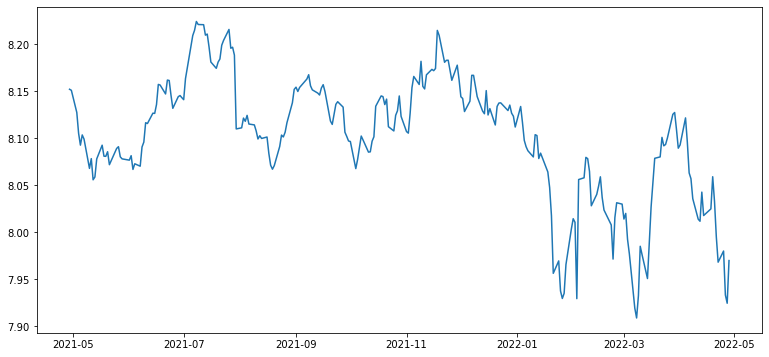

In [ ]:
''' Stationary한 시계열로 가공 '''
ts_log = np.log(ts1)
plt.plot(ts_log)

In [ ]:
''' log 취한 뒤 값 확인 ''' 
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.179615
p-value                          0.213727
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


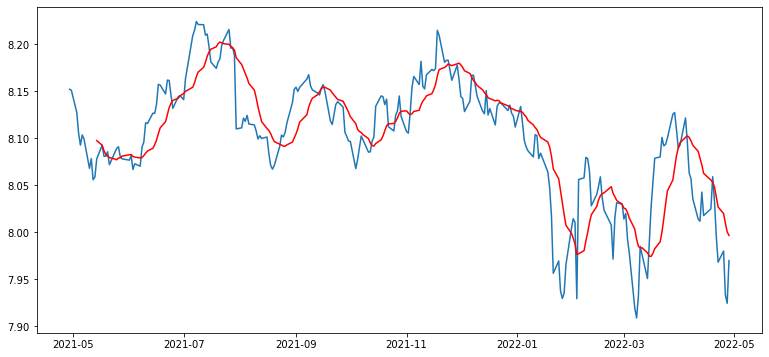

In [ ]:
''' Moving average 제거 - 추세(Trend) 상쇄하기 '''
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
''' Moving Average 계산 및 결측치(NaN) 제거 '''
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-05-14   -0.019513
2021-05-17    0.000083
2021-05-18   -0.005787
2021-05-19   -0.002039
2021-05-20    0.004494
2021-05-21   -0.007597
2021-05-24    0.006963
2021-05-25    0.012115
2021-05-26    0.012061
2021-05-27    0.001108
2021-05-28   -0.002934
2021-06-01   -0.005800
2021-06-02   -0.001331
2021-06-03   -0.013813
2021-06-04   -0.007129
Name: Close, dtype: float64

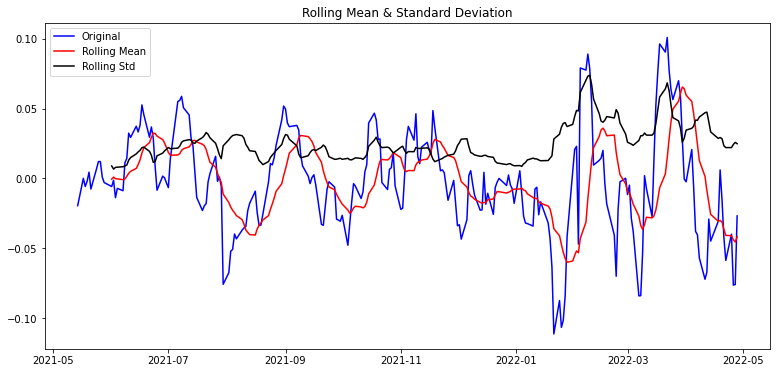

Results of Dickey-Fuller Test:
Test Statistic                  -4.641790
p-value                          0.000108
#Lags Used                       1.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [ ]:
''' ts_log_moving_avg의 정성, 정량적 분석 '''
plot_rolling_statistics(ts_log_moving_avg)

augmented_dickey_fuller_test(ts_log_moving_avg)

<br><br>

위의 테스트 결과, p-value가 0.0001 수준으로 감소했음을 알 수 있다. 이제 시계열 데이터가 정상성을 획득했다고 볼 수 있다. 

하지만 조금 더 정상성을 높여볼 수는 없을까.

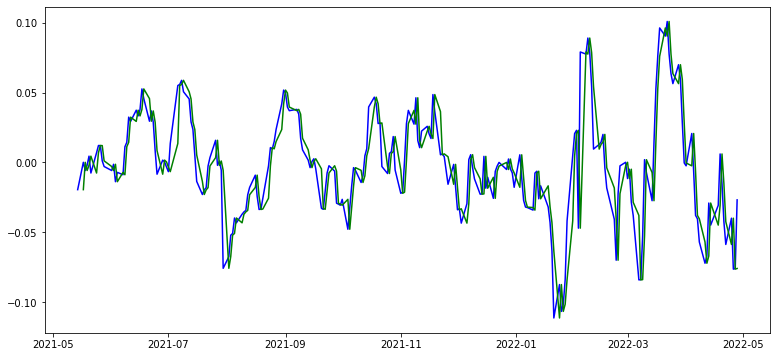

In [ ]:
''' 차분(Differencing) - 계절성(Seasonality) 상쇄하기 '''
# 시프트한 시계열과 원본 시계열에 대한 그래프 그리기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

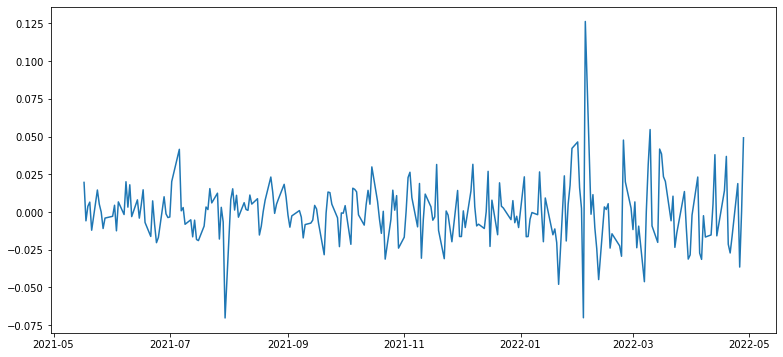

In [ ]:
# 원본 시계열에서 시프트한 시계열을 뺀 값 그래프
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

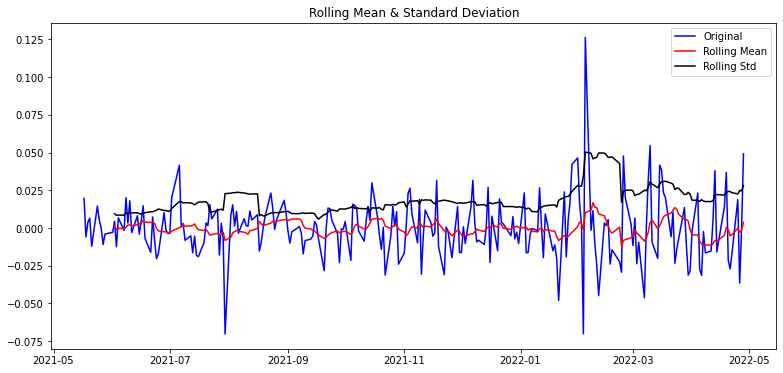

In [ ]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [ ]:
# 차분의 효과가 어떠했는지 알아보기 위한 Augmented Dickey-Fuller Test 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.482350e+01
p-value                        1.947438e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


<br><br>

p-value가 1.947438e-27로 이전에 비해 극도로 낮아졌다. 차분 및 계절성의 상쇄가 정상성 향상에 효과적이었던 것으로 판단된다.

이어서 Time series decomposition도 수행해보도록 한다.

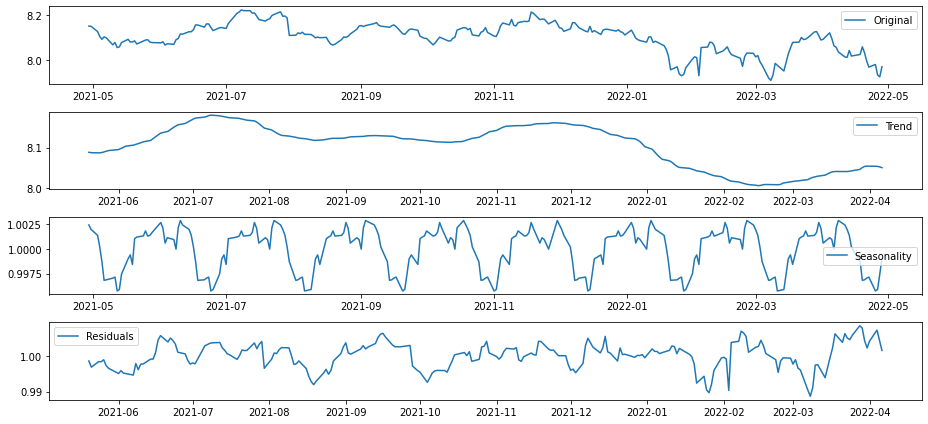

In [ ]:
''' 시계열 분해 '''
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual에 대한 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.212568
p-value                          0.000008
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


<br><br>

위의 표에서 확인할 수 있듯이 p-value가 0.000008으로 충분히 작은 값이며, 정상성을 지니고 있다. 그러나 차분까지 적용했을 때보다는 늘어났음을 알 수 있다.

학습 및 테스트를 위한 셋팅을 실시하자.

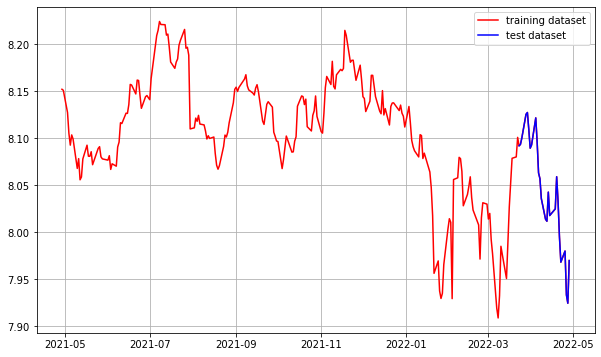

In [ ]:
''' 학습, 테스트 데이터셋 생성 '''

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

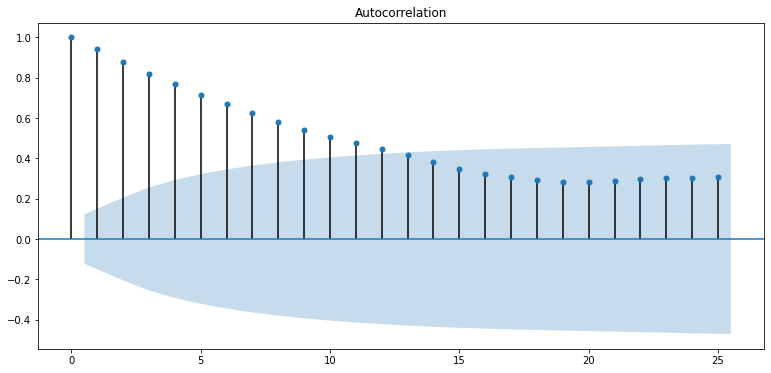

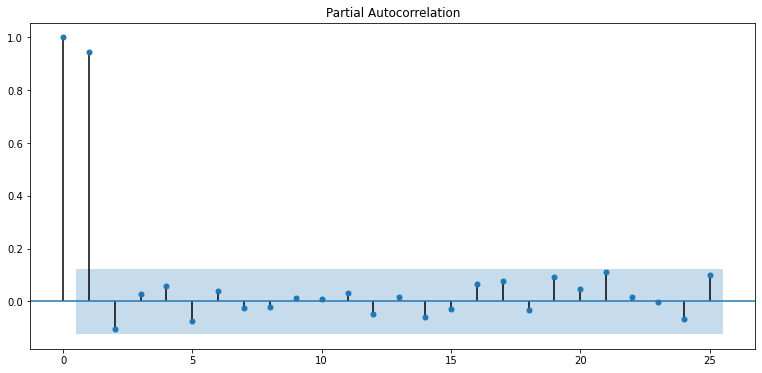

In [ ]:
''' 적정 ARIMA 모수 찾기 '''

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.529979e+01
p-value                        4.328421e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


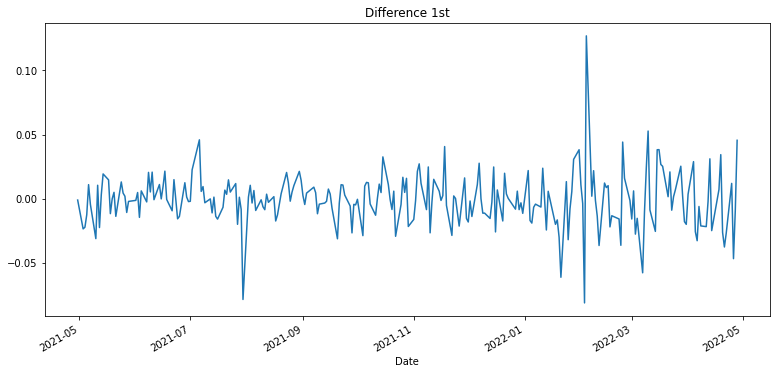

In [ ]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.841768e+00
p-value                        5.911087e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


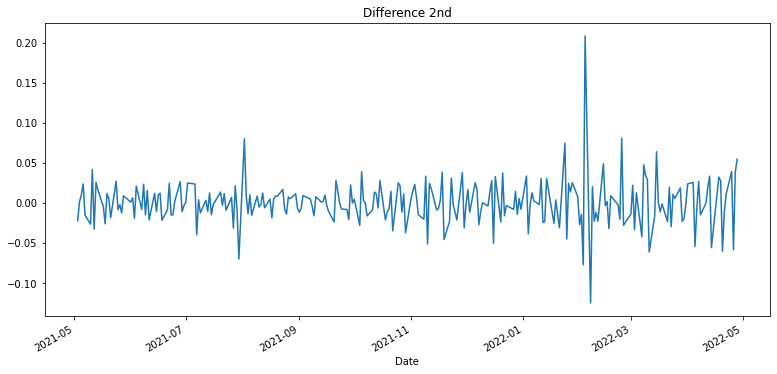

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<br><br>

그래프의 형태와 절단점의 위치를 참고하여 파라미터(모수)를 설정하였다. 차분은 1회 실시하는 것을 기준으로 삼았다.

다음은 p=2, d=1, q=13을 적용한 ARIMA model 분석결과다.

In [ ]:
''' ARIMA '''
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(2,1,13))    # 파라미터 조정 및 결과 피드백을 통해 최적값 서치 

fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                ARIMA(2, 1, 13)   Log Likelihood                 567.918
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 05 May 2022   AIC                          -1101.837
Time:                        08:39:31   BIC                          -1043.688
Sample:                             1   HQIC                         -1078.370
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.001     -0.411      0.682      -0.002       0.001
ar.L1.D.Close      1.2456      0.084     14.833      0.000       1.081       1.410
ar.L2.D.Close     -0.9206      0.108

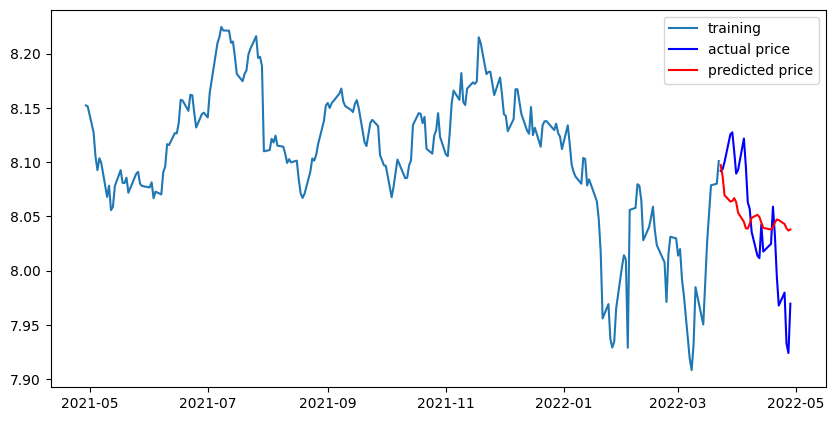

In [ ]:
''' 주가 예측 '''
# Forecast
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # array(3개) 각각 배정

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

<br><br>

다음은 모델을 평가하기 위해 MSE, MAE, RMSE, MAPE를 계산했다. 

평균절대비오차인 **MAPE**(mean absolute percentage error)를 **4.22%** 까지 낮추었다. 

In [ ]:
# 원본 스케일의 오차계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('► MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('► MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('► RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('► MAPE: {:.2f}%'.format(mape*100))

► MSE:  24802.25185931941
► MAE:  129.32482884637045
► RMSE:  157.4873069784337
► MAPE: 4.22%


<br><br><br>

###**2) 소 결**

<br>

아마존 주식 데이터를 분석하고, 데이터의 정상성(starionary)을 획득하여 시계열 예측을 실시했다. 해당 데이터 상 가장 최근의 주가(약 1개월분)을 예측하였다.

<br>

**Augmented Dickey-Fuller Test 결과**
*   데이터 가공 전 p-value(초기값): 0.23
*   데이터 가공 및 시계열 분해 후 p-value(최저값): 1.947438e-27

**ARIMA model 파라미터(모수)**
*    p=2, d=1, q=13

**예측 정확도 평가**
*   MAPE: 4.22%


<br>

ARIMA model의 파라미터(모수)를 설정하기 위해 ACF, PACF를 그래프화한 상관도표를 분석하였으며, 차분을 총 2회에 걸쳐 실시하고 그에 따른 결과를 비교하였다. 파라미터의 설정에 따라 예측 정확도가 달라진다는 것을 알 수 있었다. 실제 주가와 예측 수치를 그래프로 비교해본 결과, 주가의 경향성과 비교적 유사한 형태의 그래프가 그려졌다. 

-

<br><br><br><br><br><br>




---




##**3. NKE (나이키 Class B)**

<br><br>

###**1) 분석 및 예측**

<br>

두 번째로 분석해볼 데이터는 'NKE', 나이키 주식 데이터(나이키 Class B, 뉴욕거래소 기준)이다. 개인적으로 투자를 고민하고 있는 종목이기도 하다.

데이터를 불러온 후 Close(종가) 컬럼을 변수로 지정한다.
Series 객체임을 확인하고, head() 메서드를 이용하여 데이터 상위 행을 읽어보았다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_filepath = '/content/drive/MyDrive/data/NKE.csv'
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)  

print(f'- shape: {df2.shape}')
print(f'- data 정보: {df2.keys()}') 
print(f'{df2.info()}\n') 

ts2 = df2['Close']
print(type(ts2))
print(ts2.head())


- shape: (253, 6)
- data 정보: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-05-05 to 2022-05-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None

<class 'pandas.core.series.Series'>
Date
2021-05-05    132.210007
2021-05-06    133.490005
2021-05-07    137.809998
2021-05-10    136.399994
2021-05-11    137.119995
Name: Close, dtype: float64


<br><br>

그래프를 통해 데이터를 파악해보자.

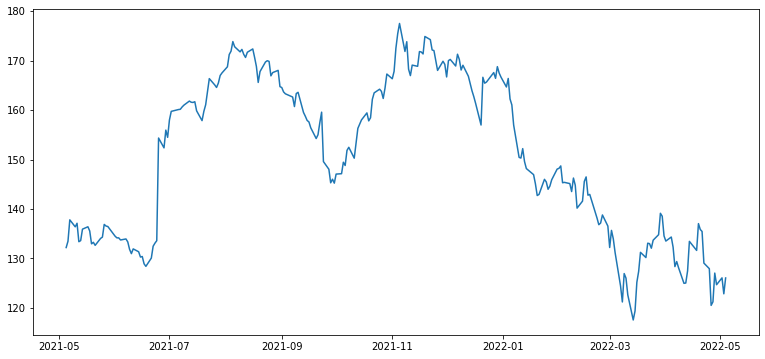

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

# 시계열(time series) 데이터 차트
plt.plot(ts2)

In [ ]:
# 결측치 측정
ts2[ts2.isna()] 

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


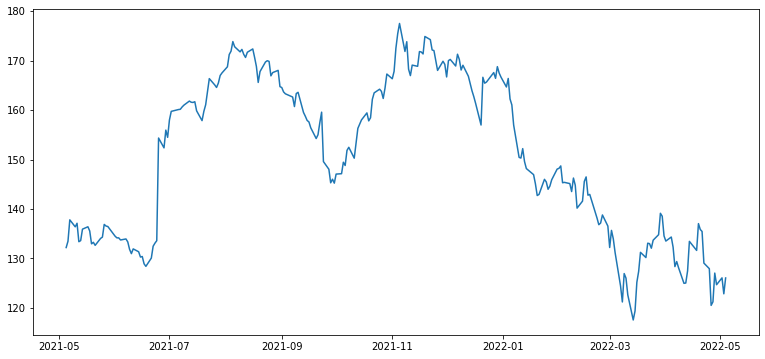

In [ ]:
# 결측치 있을 시 보간(보간기준 time) 
ts2=ts2.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무 재확인
print(ts2[ts2.isna()])

# 그래프 재확인
plt.plot(ts2)

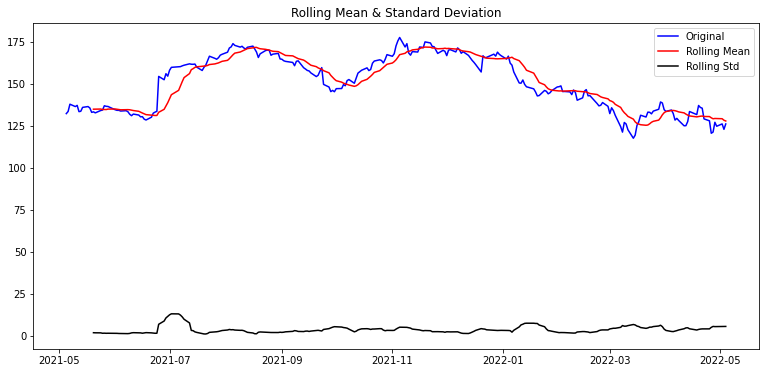

In [ ]:
''' 구간 통계치(Rolling Statistics) 시각화 '''
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 실행
plot_rolling_statistics(ts2, window=12)

In [ ]:
''' statsmodels 패키지와 adfuller 메서드 '''

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

<br><br>

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행한다.

아래 보는 것과 같이, p-value가 0.67로 현 상태로는 정상성을 지닌다고 보기 어렵다. 아직은 귀무가설을 기각할 수 없다.

In [ ]:
''' Augmented Dickey-Fuller Test 수행 '''
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.207977
p-value                          0.670155
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


<br><br>

비정상성을 지닌 시계열을 활용할 수 있도록 정상성을 높여보자. 



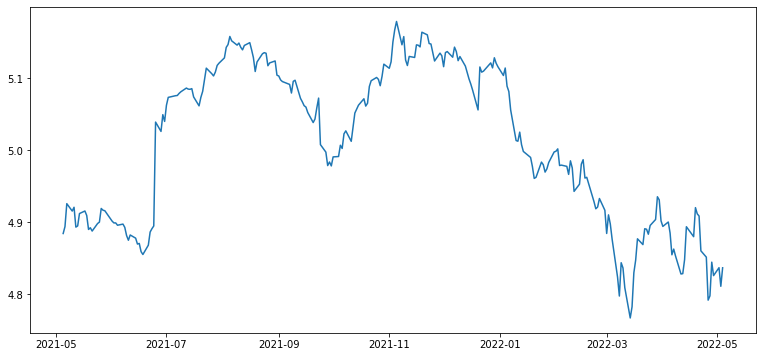

In [ ]:
''' Stationary한 시계열로 가공 '''
ts_log = np.log(ts2)
plt.plot(ts_log)

In [ ]:
''' log 취한 뒤 값 확인 ''' 
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.221245
p-value                          0.664390
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


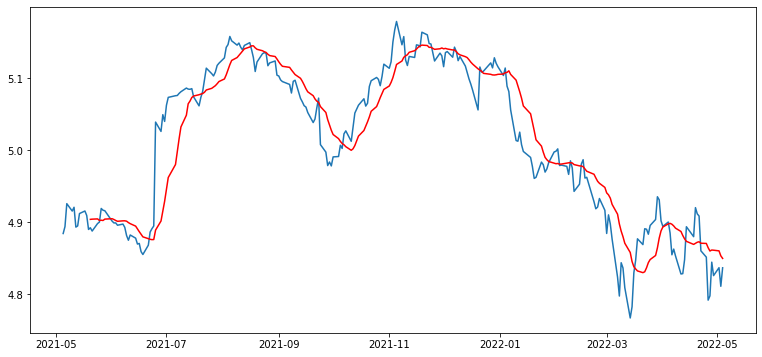

In [ ]:
''' Moving average 제거 - 추세(Trend) 상쇄하기 '''
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
''' Moving Average 계산 및 결측치(NaN) 제거 '''
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-05-20   -0.011672
2021-05-21   -0.016543
2021-05-24   -0.006400
2021-05-25   -0.002325
2021-05-26    0.016329
2021-05-27    0.014256
2021-05-28    0.011628
2021-06-01   -0.003325
2021-06-02   -0.004770
2021-06-03   -0.003390
2021-06-04   -0.005473
2021-06-07   -0.004523
2021-06-08   -0.009062
2021-06-09   -0.019933
2021-06-10   -0.024541
Name: Close, dtype: float64

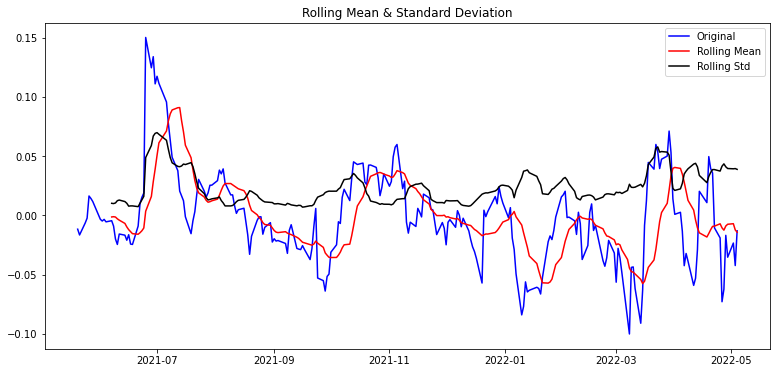

Results of Dickey-Fuller Test:
Test Statistic                  -3.879921
p-value                          0.002188
#Lags Used                       0.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


In [ ]:
''' ts_log_moving_avg의 정성, 정량적 분석 '''
plot_rolling_statistics(ts_log_moving_avg)

augmented_dickey_fuller_test(ts_log_moving_avg)

<br><br>

위의 테스트 결과, p-value가 0.002 수준으로 감소했음을 알 수 있다. 시계열 데이터가 정상성을 획득했다고 볼 수 있다. 

정상성을 조금 더 향상시켜보자.

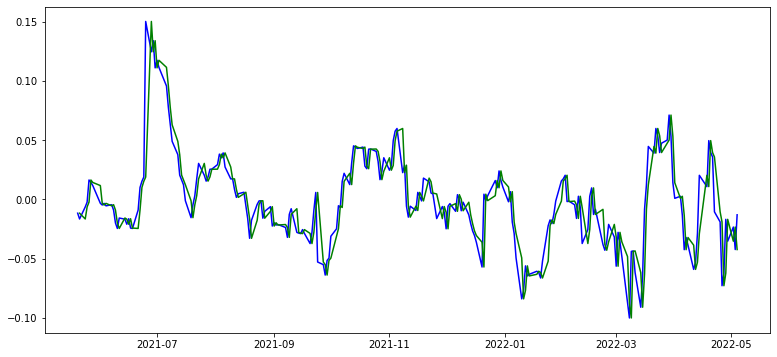

In [ ]:
''' 차분(Differencing) - 계절성(Seasonality) 상쇄하기 '''
# 시프트한 시계열과 원본 시계열에 대한 그래프 그리기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

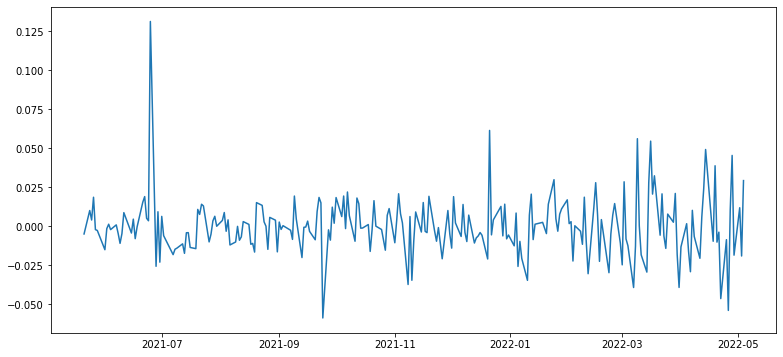

In [ ]:
# 원본 시계열에서 시프트한 시계열을 뺀 값 그래프
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

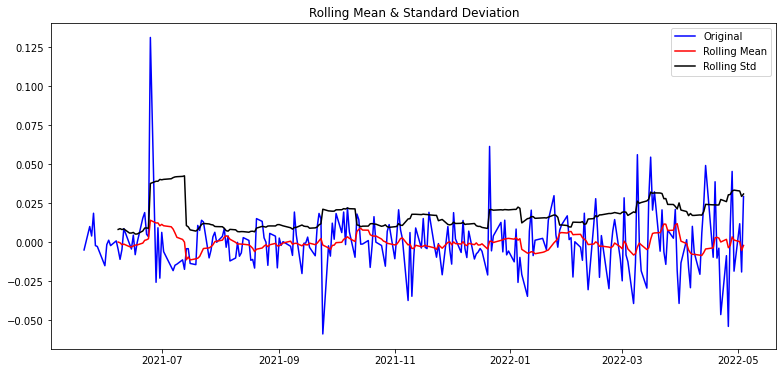

In [ ]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [ ]:
# 차분의 효과가 어떠했는지 알아보기 위한 Augmented Dickey-Fuller Test 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.539471e+01
p-value                        3.274537e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


<br><br>

p-value가 3.274537e-28로 매우 낮아졌다. 차분 및 계절성의 상쇄가 정상성 향상에 효과적이었던 것으로 판단된다.

이어서 Time series decomposition도 수행해보도록 한다.

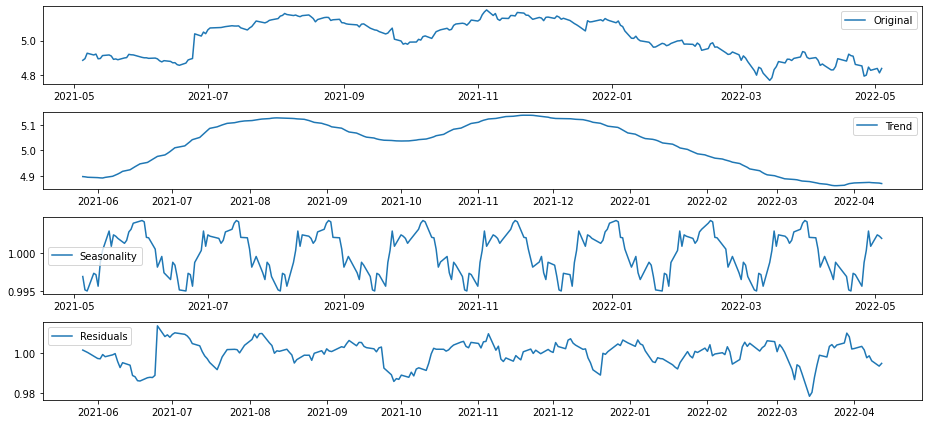

In [ ]:
''' 시계열 분해 '''
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual에 대한 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.106916e+00
p-value                        9.535774e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


<br><br>

학습 및 테스트 데이터셋을 준비하자.

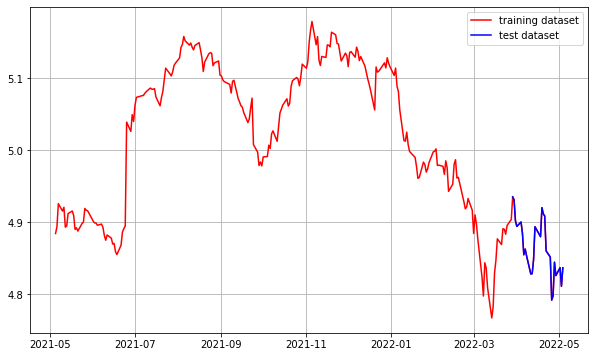

In [ ]:
''' 학습, 테스트 데이터셋 생성 '''

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

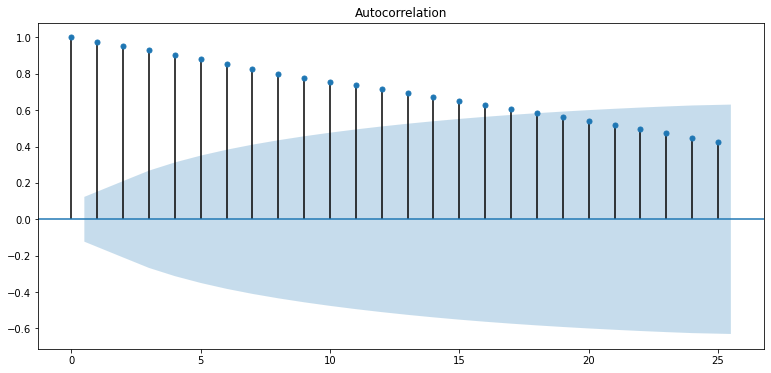

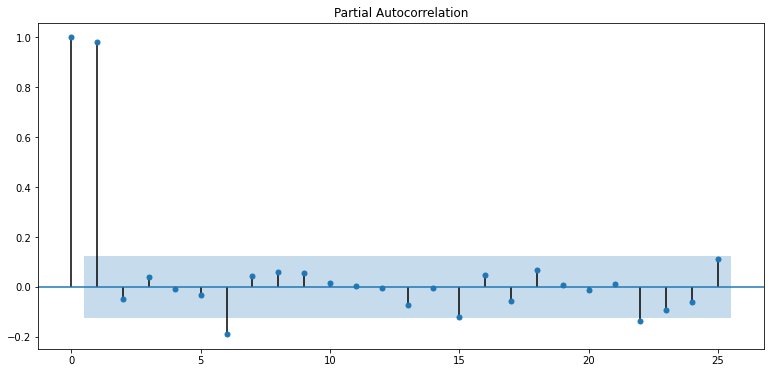

In [ ]:
''' 적정 ARIMA 모수 찾기 '''

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.564376e+01
p-value                        1.628105e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


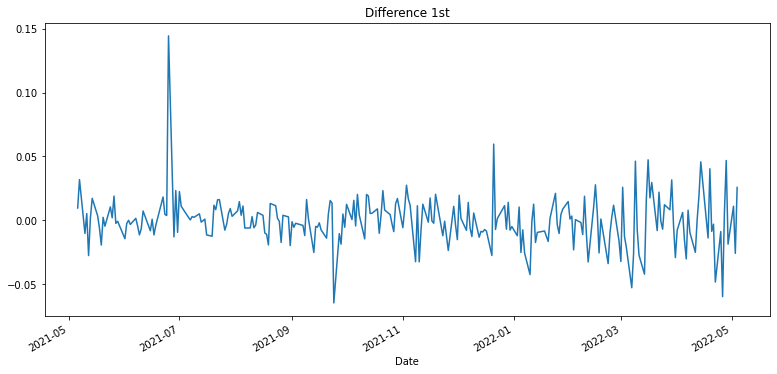

In [ ]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.668940e+00
p-value                        4.602337e-14
#Lags Used                     8.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


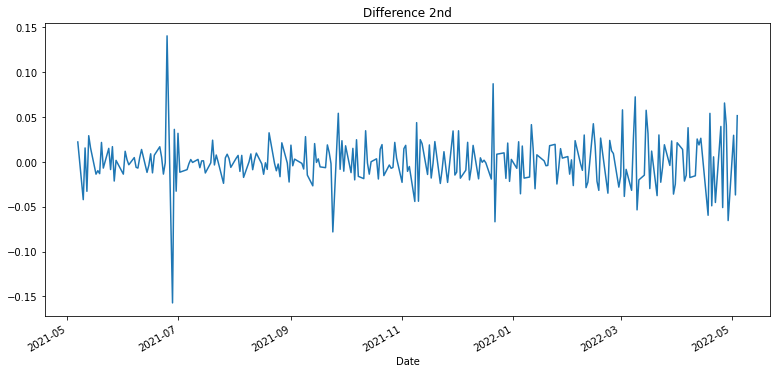

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<br><br>

그래프의 형태와 절단점의 위치를 참고하여 파라미터(모수)를 설정하였다. 차분은 1회 실시하는 것을 기준으로 삼았다. q값은 다양하게 수행하는 과정을 거쳐 최적값을 찾고자 했다.

다음은 p=1, d=1, q=0을 적용한 ARIMA model 분석결과다.

In [ ]:
''' ARIMA '''
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,0))    # 파라미터 조정 및 결과 피드백을 통해 최적값 서치

fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 580.964
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 05 May 2022   AIC                          -1155.927
Time:                        10:12:23   BIC                          -1145.666
Sample:                             1   HQIC                         -1151.786
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.768e-05      0.001      0.070      0.944      -0.002       0.003
ar.L1.D.Close     0.0189      0.066      0.284      0.777      -0.111       0.149
                                    Root

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


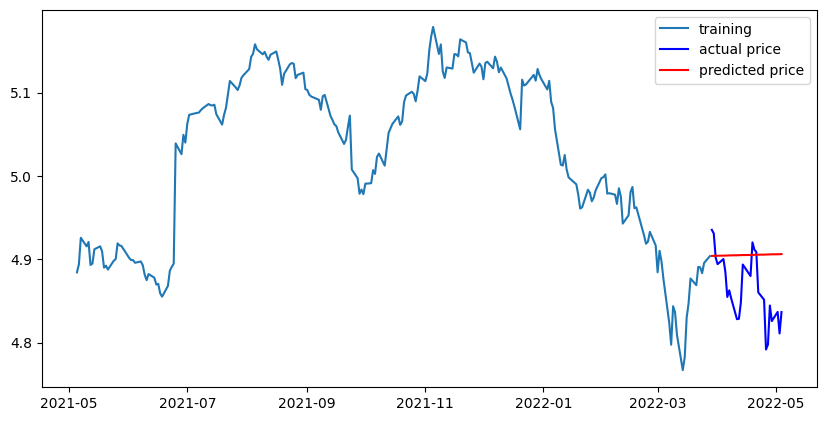

In [ ]:
''' 주가 예측 '''
# Forecast
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # array(3개) 각각 배정

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

<br><br>

다음은 모델을 평가하기 위해 MSE, MAE, RMSE, MAPE를 계산했다. 

평균절대비오차인 **MAPE**(mean absolute percentage error)를 **4.80%** 까지 낮추었다. 

In [ ]:
# 원본 스케일의 오차계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('► MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('► MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('► RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('► MAPE: {:.2f}%'.format(mape*100))

► MSE:  54.24400807249806
► MAE:  6.060609616782476
► RMSE:  7.365053161552743
► MAPE: 4.80%


<br><br><br>

###**2) 소 결**

<br>

나이키 주식 데이터를 분석하고, 데이터의 정상성(starionary)을 획득하여 시계열 예측을 실시했다. 해당 데이터 상 가장 최근의 주가(약 1개월분)을 예측하였다.

<br>

**Augmented Dickey-Fuller Test 결과**
*   데이터 가공 전 p-value(초기값): 0.67
*   데이터 가공 및 시계열 분해 후 p-value(최저값): 3.274537e-28

**ARIMA model 파라미터(모수)**
*    p=1, d=1, q=0

**예측 정확도 평가**
*   MAPE: 4.80%


<br>

ARIMA model의 파라미터를 설정하는 데에 가장 어려움이 있었던 프로젝트였다. 그래프의 형태와 절단점의 위치를 참고하여 초기 파라미터값을 넣었으나, 예측 정확도가 만족스럽지 않아 여러차례 값을 다르게 설정하고 피드백하는 과정을 반복했다. 특히 그래프를 통해 처음 추정한 적정 q값(q=17)이 높아 ARIMA model을 fit하고, result report를 추출하는데 런타임이 오래 걸렸다. 그럼에도 예측 정확도가 높지 않아 수차례 값을 조정했고, 결국 MA를 고려할 필요성이 높지 않다고 판단하여 q=0으로 최종 설정했다. 실제 예측결과도 이때에 가장 높았다.

그래프의 형태와 절단점을 통해 획득한 파라미터가 예상보다 낮은 성능을 보일 때, 이처럼 경험적으로 파라미터를 찾는 것이 최선인지 궁금하다.


-

<br><br><br><br><br><br>




---

# **III. 결 론**

<br>

####**[ 맺음말 ]**

시계열 데이터가 정상성(starionary)을 갖지 않을 때, 이를 가공∙변형하거나 분해(decomposition)함으로써 안정적인 패턴의 데이터로 만들 수 있다는 게 새로웠다. 다만, 이렇게 가공된 데이터가 현실세계를 얼마나 정확하게 예측할 수 있는지에 대한 의구심이 생기기도 했다. 예측의 정확도를 측정하는 방법을 익히고 오차를 줄여나가는 과정을 경험했지만, 얼마큼의 오차율을 허용할 것인지, 얼만큼의 정확도가 유의미한지 판단하는 것은 별개의 문제다. 어떤 예측도 완벽하게 정확할 순 없겠으나, 통계적 유의성을 분별하고 예측의 결과를 제대로 분석할 수 있는 혜안은 반드시 갖추어야 한다는 생각이 들었다. 

<br>

####**[ 향후 과제 ]**

시계열 분석 및 예측을 이해하는데 있어서 통계학적 기초가 너무나 부족함을 깨달았다. 하루이틀 공부해서 될 문제는 아닌 것 같다. 어디서부터 얼마나 깊이있게 공부해야할지 헤아려지지 않는 막막한 기분도 든다. 과제만 늘어간다.




            
<br><br><br>



---

<br>

< 참고자료 >

- Forecasting: Principles and Practice, https://otexts.com/fppkr
- 시계열(Time series), https://direction-f.tistory.com/65
- ACF∙PACF의 이해, https://aliencoder.tistory.com/9 [1]

<br><br>

---

